In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

import EDA
import regression
import outlier


df = pd.read_csv('ship-data.csv')
train_index = int(df.shape[0] * .8)
df_train = df[:train_index]
df_test = df[train_index:]

# Speed
v = df[df.columns[11]].values
u = df[df.columns[12]].values
x = np.concatenate([v.reshape(-1, 1), u.reshape(-1, 1)], axis=1)
prd = outlier.Rc(x).fit(.002)
df.loc[prd == -1, 'Speed Through Water (knots)'] = df.loc[prd == -1, 'Speed Over Ground (knots)']

# Draft
df.loc[df[df.columns[6]]==0, df.columns[6]] = df.loc[df[df.columns[6]]==0, df.columns[7]]
df.loc[791:796, df.columns[19]] = df.loc[781:790, df.columns[19]].mean()
df.loc[2194:2211, df.columns[19]] = df.loc[2192:2193, df.columns[19]].mean()

# Power
power = ['Time', 'Shaft Speed (RPM)', 'Shaft Torque (kNm)',
       'Shaft Power (kW)']
df_all = df.drop(power, 1)

df_train = df_all[:train_index]
df_test = df_all[train_index:]

xtr = df_train.drop('Main Engine Fuel Consumption (MT/day)', 1).values
ytr = df_train['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

xte = df_test.drop('Main Engine Fuel Consumption (MT/day)', 1).values
yte = df_test['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

df1 = df_all.drop('Speed Over Ground (knots)', 1)
df1['Trim'] = df1['Draft Forward (meters)'] - df1['Draft Aft (meters)']

pca = PCA(n_components=1, random_state=42)
df1['Draft'] = pca.fit_transform(df.iloc[:, 4:8])

# Wind
wind = ['Weather Service True Wind Speed (knots)', 'Weather Service True Wind Direction (degrees from north)']
df3 = df1.drop(wind, 1)

# Current
df3['Apparent Current Direction'] = df3['Heading (degrees)'] - df3['Weather Service Sea Current Direction (degrees from north)']
df3['Apparent Current Speed'] = df3['Weather Service Sea Current Speed (knots)'] * np.cos(df3['Apparent Current Direction'])
current = ['Weather Service Sea Current Speed (knots)', 'Weather Service Sea Current Direction (degrees from north)']
df4 = df3.drop(current, 1)

df_train = df4[:train_index]
df_test = df4[train_index:]

xtr = df_train.drop('Main Engine Fuel Consumption (MT/day)', 1).values
ytr = df_train['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

xte = df_test.drop('Main Engine Fuel Consumption (MT/day)', 1).values
yte = df_test['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

model = regression.Rf(xtr, ytr)
model.fit()

model.model.fit(xtr, ytr)
regression.Test(model.model, xte, yte).score()

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tianyi/Documents/data_practice/VesselTimeSeries/regression.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.xtr, self.ytr)


Train set accuracy:
0.9987387992638139
Test set accuracy:
0.9930295147835023


/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy:
0.9796771211486933
RMSE:
2.379739120980619
MAE:
1.5732236091085188


In [55]:
x = df4.drop('Main Engine Fuel Consumption (MT/day)', 1).values
y = df4['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)
model.model.fit(x, y)

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [5]:
model.feature_importance(df_train.drop('Main Engine Fuel Consumption (MT/day)', 1).columns)

,Feature_Importance
Speed Through Water (knots),0.951579
Weather Service Apparent Wind Speed (knots),0.014393
Draft Aft (meters),0.007446
Draft Mid-2 (meters),0.007059
Draft,0.005132
Draft Forward (meters),0.002899
Weather Service Temperature (celsius),0.002666
Heading (degrees),0.002308
Draft Mid-1 (meters),0.001780
Trim,0.001769


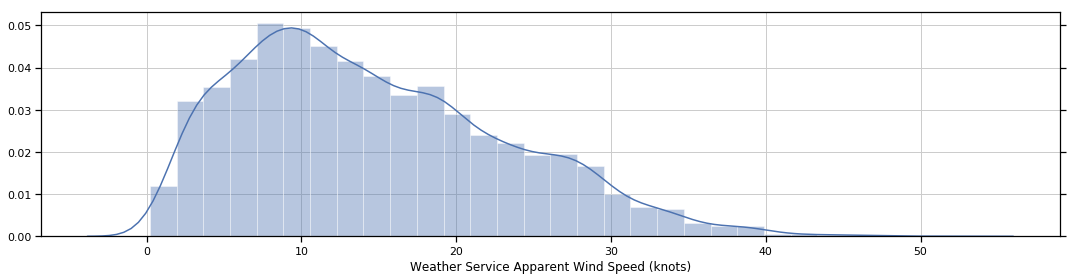

count    14040.000000
mean        14.665744
std          8.580036
min          0.216047
25%          7.969310
50%         13.247204
75%         20.267002
max         51.955335
Name: Weather Service Apparent Wind Speed (knots), dtype: float64


In [79]:
vs = EDA.Visual(df4)
vs.hist('Weather Service Apparent Wind Speed (knots)')

In [28]:
df_wind = pd.DataFrame(columns=df4.drop('Main Engine Fuel Consumption (MT/day)', 1).columns)

In [44]:
for c in df_wind.columns:
    df_wind[c] = df4[c].mean()

In [45]:
df_wind['Speed Through Water (knots)'] = np.arange(0,18, .1)

In [61]:
df_wind.loc[:, 'Weather Service Apparent Wind Speed (knots)'] = 10

In [62]:
df_vs = df_wind.copy()
df_vs.loc[:, 'Main Engine Fuel Consumption (MT/day)'] = model.model.predict(df_wind)

In [52]:
import matplotlib.pyplot as plt

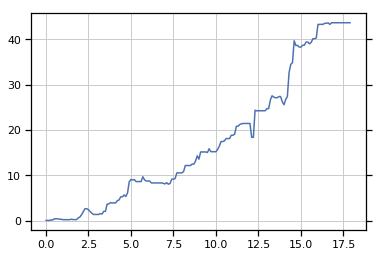

In [63]:
plt.plot(np.arange(0,18, .1), model.model.predict(df_wind))
plt.show()

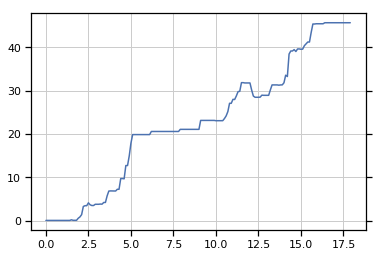

In [64]:
df_wind.loc[:, 'Weather Service Apparent Wind Speed (knots)'] = 30
df_vs = df_wind.copy()
df_vs.loc[:, 'Main Engine Fuel Consumption (MT/day)'] = model.model.predict(df_wind)
plt.plot(np.arange(0,18, .1), model.model.predict(df_wind))
plt.show()

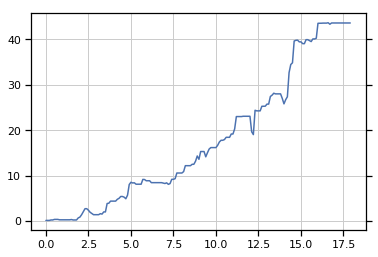

In [76]:
df_wind.loc[:, 'Weather Service Apparent Wind Speed (knots)'] = 10
df_vs = df_wind.copy()
df_vs.loc[:, 'Main Engine Fuel Consumption (MT/day)'] = model.model.predict(df_wind)
plt.plot(np.arange(0,18, .1), model.model.predict(df_wind))
plt.show()

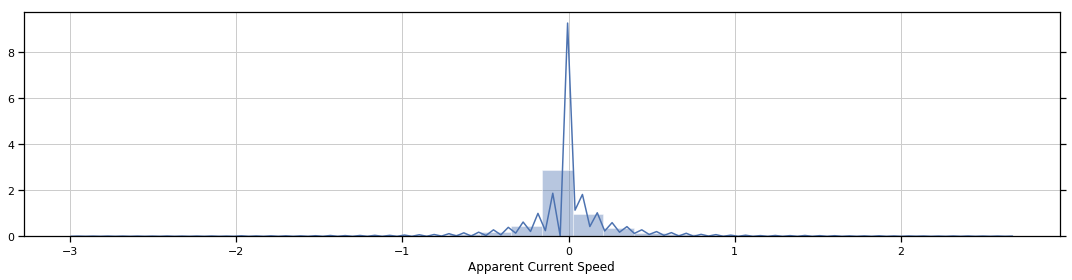

count    14040.000000
mean         0.004675
std          0.352470
min         -2.948787
25%         -0.061696
50%          0.000000
75%          0.069468
max          2.625056
Name: Apparent Current Speed, dtype: float64


In [80]:
vs = EDA.Visual(df4)
vs.hist('Apparent Current Speed')

In [84]:
df_current = pd.DataFrame(columns=df4.drop('Main Engine Fuel Consumption (MT/day)', 1).columns)
df_current['Speed Through Water (knots)'] = np.arange(0,18, .1)
for c in df_current.columns:
    df_current[c] = df4[c].mean()
df_current['Speed Through Water (knots)'] = np.arange(0,18, .1)

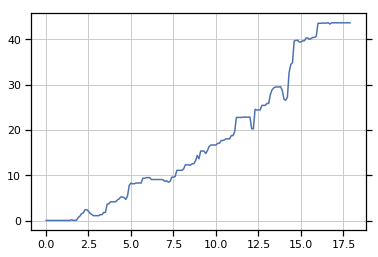

In [86]:
df_current.loc[:, 'Apparent Current Speed'] = .2
plt.plot(np.arange(0,18, .1), model.model.predict(df_current))
plt.show()

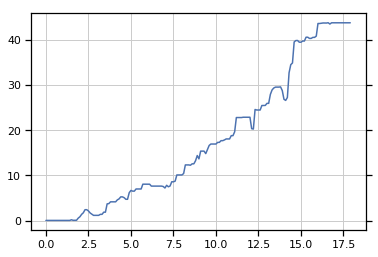

In [87]:
df_current.loc[:, 'Apparent Current Speed'] = -.2
plt.plot(np.arange(0,18, .1), model.model.predict(df_current))
plt.show()

In [126]:
df5 = pd.DataFrame(columns=df4.drop('Main Engine Fuel Consumption (MT/day)', 1).columns)
df5['Speed Through Water (knots)'] = np.arange(0,18, .1)

df5['Main Engine Using HFO (bool)'] = 1
df5['Main Engine Using MGO (bool)'] = 0
df5['Draft Forward (meters)'] = 6
df5['Draft Aft (meters)'] = 8
df5['Draft Mid-1 (meters)'] = 6
df5['Draft Mid-2 (meters)'] = 6
df5['Heading (degrees)'] = 180
df5['Rudder Angle (degrees)'] = 360
df5['Weather Service Apparent Wind Speed (knots)'] = 10
df5['Weather Service Apparent Wind Direction (degrees from bow)'] = 0
df5['Weather Service Temperature (celsius)'] = 20
df5['Water Depth (meters)'] = 0
df5['Trim'] = 0
df5['Draft'] = -2
df5['Apparent Current Direction'] = 70
df5['Apparent Current Speed'] = 0

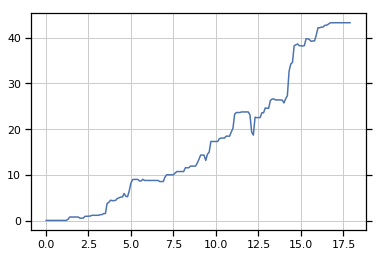

In [98]:
plt.plot(np.arange(0,18, .1), model.model.predict(df5))
plt.show()


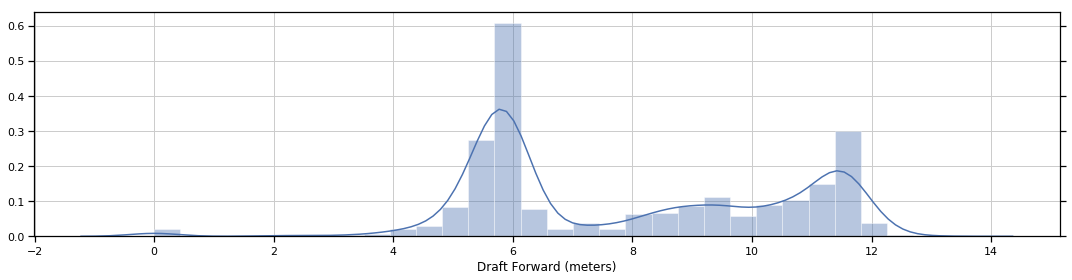

count    14040.000000
mean         7.905617
std          2.609205
min          0.000000
25%          5.766836
50%          6.829718
75%         10.587904
max         13.136587
Name: Draft Forward (meters), dtype: float64


In [100]:
vs = EDA.Visual(df4)
vs.hist('Draft Forward (meters)')

In [148]:
df6 = df4.loc[(df['Draft Mid-1 (meters)'] < 14) & (df['Draft Mid-1 (meters)'] > 9)
       & (df['Weather Service Apparent Wind Speed (knots)'] < 11) & (df['Weather Service Apparent Wind Speed (knots)'] > 9)]

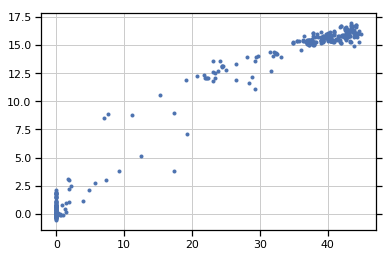

In [149]:
plt.scatter(df6.iloc[:, 0], df6.iloc[:, 7], marker='.')
plt.show()

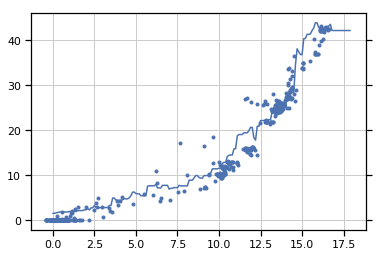

In [178]:
df6 = df4.loc[(df['Draft Mid-1 (meters)'] < 7) & (df['Draft Mid-1 (meters)'] > 5)
       & (df['Weather Service Apparent Wind Speed (knots)'] < 11) & (df['Weather Service Apparent Wind Speed (knots)'] > 9)]

df5 = pd.DataFrame(columns=df4.drop('Main Engine Fuel Consumption (MT/day)', 1).columns)
df5['Speed Through Water (knots)'] = np.arange(0,18, .1)

df5['Main Engine Using HFO (bool)'] = 1
df5['Main Engine Using MGO (bool)'] = 0
df5['Draft Forward (meters)'] = 6
df5['Draft Aft (meters)'] = 6
df5['Draft Mid-1 (meters)'] = 10
df5['Draft Mid-2 (meters)'] = 10
df5['Heading (degrees)'] = 0
df5['Rudder Angle (degrees)'] = 0
df5['Weather Service Apparent Wind Speed (knots)'] = 0
df5['Weather Service Apparent Wind Direction (degrees from bow)'] = 0
df5['Weather Service Temperature (celsius)'] = 10
df5['Water Depth (meters)'] = 50
df5['Trim'] = -2
df5['Draft'] = -4
df5['Apparent Current Direction'] = 0
df5['Apparent Current Speed'] = 0

plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.')
plt.plot(np.arange(0,18, .1), model.model.predict(df5))
plt.show()

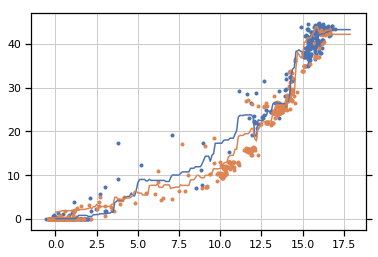

In [181]:
df6 = df4.loc[(df['Draft Mid-1 (meters)'] < 14) & (df['Draft Mid-1 (meters)'] > 9)
       & (df['Weather Service Apparent Wind Speed (knots)'] < 11) & (df['Weather Service Apparent Wind Speed (knots)'] > 9)]

df5 = pd.DataFrame(columns=df4.drop('Main Engine Fuel Consumption (MT/day)', 1).columns)
df5['Speed Through Water (knots)'] = np.arange(0,18, .1)

df5['Main Engine Using HFO (bool)'] = 1
df5['Main Engine Using MGO (bool)'] = 0
df5['Draft Forward (meters)'] = 10
df5['Draft Aft (meters)'] = 10
df5['Draft Mid-1 (meters)'] = 10
df5['Draft Mid-2 (meters)'] = 10
df5['Heading (degrees)'] = 180
df5['Rudder Angle (degrees)'] = 360
df5['Weather Service Apparent Wind Speed (knots)'] = 10
df5['Weather Service Apparent Wind Direction (degrees from bow)'] = 0
df5['Weather Service Temperature (celsius)'] = 20
df5['Water Depth (meters)'] = 0
df5['Trim'] = 0
df5['Draft'] = -2
df5['Apparent Current Direction'] = 70
df5['Apparent Current Speed'] = 0

plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.')
plt.plot(np.arange(0,18, .1), model.model.predict(df5))

df6 = df4.loc[(df['Draft Mid-1 (meters)'] < 7) & (df['Draft Mid-1 (meters)'] > 5)
       & (df['Weather Service Apparent Wind Speed (knots)'] < 11) & (df['Weather Service Apparent Wind Speed (knots)'] > 9)]

df5 = pd.DataFrame(columns=df4.drop('Main Engine Fuel Consumption (MT/day)', 1).columns)
df5['Speed Through Water (knots)'] = np.arange(0,18, .1)

df5['Main Engine Using HFO (bool)'] = 1
df5['Main Engine Using MGO (bool)'] = 0
df5['Draft Forward (meters)'] = 6
df5['Draft Aft (meters)'] = 6
df5['Draft Mid-1 (meters)'] = 10
df5['Draft Mid-2 (meters)'] = 10
df5['Heading (degrees)'] = 0
df5['Rudder Angle (degrees)'] = 0
df5['Weather Service Apparent Wind Speed (knots)'] = 0
df5['Weather Service Apparent Wind Direction (degrees from bow)'] = 0
df5['Weather Service Temperature (celsius)'] = 10
df5['Water Depth (meters)'] = 50
df5['Trim'] = -2
df5['Draft'] = -4
df5['Apparent Current Direction'] = 0
df5['Apparent Current Speed'] = 0

plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.')
plt.plot(np.arange(0,18, .1), model.model.predict(df5))
plt.show()